This notebook will cover
* Logistic Regression
* Linear Discriminant Analysis
* Quadratic Discriminant Analysis

In [2]:

# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set()
%matplotlib inline

In [3]:
df = pd.read_excel('../data/Default.xlsx')

df['default2'] = df['default'].factorize()[0]
df['student2'] = df['student'].factorize()[0]
df.head(3)

,default,student,balance,income,default2,student2
1,No,No,729.526495,44361.625074,0,0
2,No,Yes,817.180407,12106.134700,0,1
3,No,No,1073.549164,31767.138947,0,0


In [10]:
# converts yes no into 0 or 1
df['default'].factorize()

(array([0, 0, 0, ..., 0, 0, 0]), Index(['No', 'Yes'], dtype='object'))

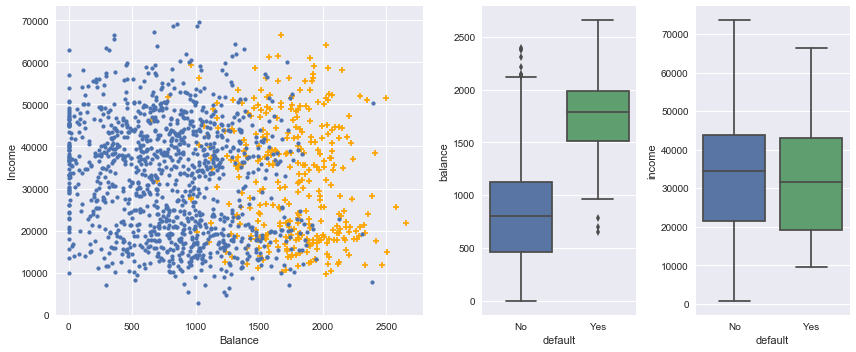

In [53]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1,4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df['default2'] == 0].sample(frac=0.12)
# Take all samples where target value is 'yes'
df_yes = df[df['default2'] == 1]
df_ = df_no.append(df_yes)

ax1.scatter (df_[df_['default'] == 'Yes']['balance'], df_[df_['default'] == 'Yes']['income'], c='orange', s=40, marker='+',
             linewidths=1)
ax1.scatter (df_[df_['default'] == 'No']['balance'], df_[df_['default'] == 'No']['income'], c=sns.color_palette()[0] ,s=10, marker='o',
             linewidths=1)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

sns.boxplot('default','balance', data=df, orient='v', ax=ax2)
sns.boxplot('default','income', data=df, orient='v', ax=ax3)
gs.tight_layout(plt.gcf())

## Logistic Regression

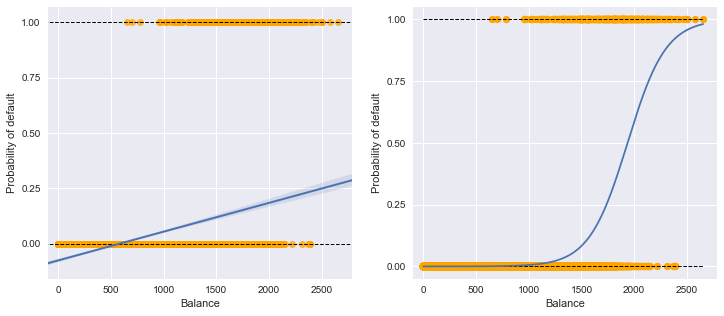

In [67]:
X_train = df['balance'].values.reshape(-1,1)
y = df['default2']

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df['balance'].min(), df['balance'].max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
#Left plot
sns.regplot(df['balance'], df['default2'], order= 1, scatter_kws={'color':'orange'}, line_kws={'color':sns.color_palette()[0], 'lw':2}, ax= ax1)
# Right plot
ax2.scatter(X_train, y, color='orange')
ax2.plot(X_test, prob[:,1], color=sns.color_palette()[0])

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

In [65]:
 df['balance'].values.reshape(-1,1)

array([[ 729.52649521],
       [ 817.18040656],
       [1073.54916401],
       ...,
       [ 845.41198922],
       [1569.00905338],
       [ 200.92218263]])

In [68]:
# Using newton-cg solver, the coefficients are equal/closest to the ones in the book. 
# I do not know the details on the differences between the solvers.
clf = skl_lm.LogisticRegression(solver='newton-cg')
X_train = df['balance'].values.reshape(-1,1)
clf.fit(X_train,y)
print(clf)
print('classes: ',clf.classes_)
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
classes:  [0 1]
coefficients:  [[0.00549891]]
intercept : [-10.65131761]


 The following two summaries show that balance is a good predictor of whther someone will default or not (duh)
 examine the column p > |z|. The super low value for Balance tells us that the chance that the two aren't correlated is effectively 0. It also shows strong evidence that being a student is correlated to whether someone will default or not. However, income doesn't seem to have an effect on defaulting.

In [70]:
X_train = sm.add_constant(df['balance'])
est = smf.Logit(y.ravel(), X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.651331,0.361169,-29.491287,3.723665e-191,-11.359208,-9.943453
balance,0.005499,0.000220,24.952404,2.010855e-137,0.005067,0.005931


In [73]:
X_train = sm.add_constant(df['student2'])
y = df['default2']

est = smf.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.145434
         Iterations 7


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-3.504128,0.070713,-49.554094,0.000000,-3.642723,-3.365532
student2,0.404887,0.115019,3.520177,0.000431,0.179454,0.630320


In [75]:
X_train = sm.add_constant(df[['balance', 'income', 'student2']])
est = smf.Logit(y, X_train).fit()
est.summary2().tables[1]

Optimization terminated successfully.
         Current function value: 0.078577
         Iterations 10


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
const,-10.869045,0.492273,-22.079320,4.995499e-108,-11.833882,-9.904209
balance,0.005737,0.000232,24.736506,4.331521e-135,0.005282,0.006191
income,0.000003,0.000008,0.369808,7.115254e-01,-0.000013,0.000019
student2,-0.646776,0.236257,-2.737595,6.189022e-03,-1.109831,-0.183721


### Confusion matrix for the logistic regression

In [81]:
# balance and default vectors for students
X_train = df[df.student == 'Yes'].balance.values.reshape(-1,1) 
y = df[df.student == 'Yes'].default2

# balance and default vectors for non-students
X_train2 = df[df.student == 'No'].balance.values.reshape(-1,1) 
y2 = df[df.student == 'No'].default2

# Vector with balance values for plotting
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf2 = skl_lm.LogisticRegression(solver='newton-cg')

clf.fit(X_train,y)
clf2.fit(X_train2,y2)

prob = clf.predict_proba(X_test)
prob2 = clf2.predict_proba(X_test)
df.groupby(['student','default']).size().unstack('default')

default,No,Yes
student,,
No,6850,206
Yes,2817,127


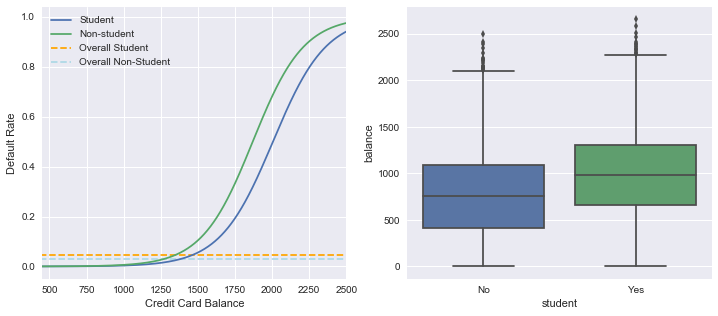

In [84]:
# creating plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.plot(X_test, pd.DataFrame(prob)[1], label='Student')
ax1.plot(X_test, pd.DataFrame(prob2)[1], label='Non-student')
ax1.hlines(127/2817, colors='orange', label='Overall Student', xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.hlines(206/6850, colors='lightblue', label='Overall Non-Student', xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dashed')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Credit Card Balance')
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.])
ax1.set_xlim(450,2500)
ax1.legend(loc=2)

# Right plot
sns.boxplot('student', 'balance', data=df, orient='v', ax=ax2);

## Linear Discriminant Analysis

In [9]:
X = df[['balance', 'income', 'student2']].values
y = df['default'].values

lda = LinearDiscriminantAnalysis(solver='svd')
y_pred = lda.fit(X,y).predict(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_pred})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9645,254
Yes,22,79


In [10]:
print(classification_report(y, y_pred, target_names=['No','Yes']))

             precision    recall  f1-score   support

         No       0.97      1.00      0.99      9667
        Yes       0.78      0.24      0.36       333

avg / total       0.97      0.97      0.97     10000



Even though our classifier is 97% accurate, this is overshadowed by the fact that there's only slightly more than 1% of the samples which would be classified as "yes", so in fact our classifier does __*worse*__ than a naive "No" classifier

In [25]:
decision_prob = 0.35
y_prob = lda.fit(X,y).predict_proba(X)

df_ = pd.DataFrame({'True default status': y,
                    'Predicted default status': y_prob[:,1] > decision_prob})
df_.replace(to_replace={0:'No', 1:'Yes'}, inplace=True)

df_.groupby(['Predicted default status','True default status']).size().unstack('True default status')

True default status,No,Yes
Predicted default status,,
No,9607,207
Yes,60,126
